# Baseline Code

In [ ]:
#launch in colab
!pip install wandb

In [3]:
!wandb login

wandb: You can find your API key in your browser here: https://app.wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: dff003aa03e7d25df35a840b6f0660ae9675efb4
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
Successfully logged in to Weights & Biases!


In [2]:
#launch in colab
from google.colab import drive
drive.mount('/content/drive/')

ModuleNotFoundError: No module named 'google'

In [1]:
#GPU INFO
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime → "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Apr 30 22:55:24 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 425.45       Driver Version: 425.45       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 105... WDDM  | 00000000:01:00.0 Off |                  N/A |
| N/A   51C    P8    N/A /  N/A |     75MiB /  4096MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [1]:
import sys

In [2]:
##launch in colab
# sys.path.append('/content/drive/My Drive/Colab_Notebooks/pfm/')

In [3]:
# Internal files
import config
import dataloader
import models

# Pytorch libraries
import torch
import torch.backends.cudnn as cudnn

import os
import time

import wandb

In [11]:
def get_model():

    # Get model from config
    if config.model == "resnet18":
        model = models.resnet18(pretrained=config.pretrained)
    elif config.model == "resnet34":
        model = models.resnet34(pretrained=config.pretrained)
    elif config.model == 'resnet50':
        model = models.resnet50(pretrained=config.pretrained)
    elif config.model == "resnet101":
        model = models.resnet101(pretrained=config.pretrained)
    elif config.model == "resnet152":
        model = models.resnet152(pretrained=config.pretrained)
    elif config.model == "resnext50_32x4d":
        model = models.resnet34(pretrained=config.pretrained)
    elif config.model == 'resnext101_32x8d':
        model = models.resnet50(pretrained=config.pretrained)
    elif config.model == "wide_resnet50_2":
        model = models.resnet101(pretrained=config.pretrained)
    elif config.model == "wide_resnet101_2":
        model = models.resnet152(pretrained=config.pretrained)
    else:
        raise ValueError('%s not supported'.format(config.model))

    # Initialize fc layer
    (in_features, out_features) = model.fc.in_features, model.fc.out_features
    model.fc = torch.nn.Linear(in_features, out_features)
    return model


def scheduler(epoch: int):
    global lr
    lr = config.lr
    if epoch > config.start_epoch:
        lr = lr / 10.0
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr


def save_checkpoint(state, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if config.use_wandb == True:
        wandb.save(filename)

def save_weights(epoch):
        print('| Saving Weights ...', end="\r")
        save_point = config.drive_dir + '/checkpoint/' + config.checkpoint + '_' + str(epoch) + '.pth.tar'
        save_checkpoint({'state_dict': net.state_dict(), }, save_point)

In [12]:
# Training
def train(epoch):
  net.train()
  train_loss = 0
  correct = 0
  total = 0
  scheduler(epoch)

  # print("train before dataloader")
  for step, (inputs, targets) in enumerate(train_loader):
      init_time = time.time()
      if use_cuda:  # GPU settings
          (inputs, targets) = inputs.cuda(), targets.cuda()
      optimizer.zero_grad()
      outputs = net(inputs)
      loss = criterion(outputs, targets)
      loss.backward()
      optimizer.step()

      train_loss += loss.data.item()
      _, predicted = torch.max(outputs.data, 1)
      total += targets.size(0)
      correct += predicted.eq(targets.data).cpu().sum()

      # Grab training results
      # print("| Epoch: {}/{}, step: {}/{}, loss: {:.3f}, acc: {:.3f}, time: {:.3f}".format(epoch,config.num_epochs,step + 1,len(train_loader.dataset),loss.data.item(),100. * correct / total,time.time() - init_time))
      # print("| Epoch: {}/{}, step: {}/{}, loss: {:.3f}, acc: {:.3f}, time: {:.3f}".format(epoch,config.num_epochs,step + 1,len(train_loader.dataset),loss.data.item(),100. * correct / total,time.time() - init_time),end="\r")
      
      sys.stdout.write('\r')
      sys.stdout.write('| Epoch [%3d/%3d] Iter[%3d/%3d]\t\tLoss: %.4f Acc@1: %.3f%%, time: %.3f'
              %(epoch, config.num_epochs, step+1, (len(train_loader.dataset)//config.batch_size)+1, loss.data.item(), 100.*correct/total,time.time() - init_time))
      sys.stdout.flush()

def valid(epoch):
    global best_acc
    net.eval()
    # valid_loss = 0
    correct = 0
    total = 0
    for step, (inputs, targets) in enumerate(valid_loader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        with torch.no_grad():
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            # valid_loss += loss.data.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += predicted.eq(targets.data).cpu().sum()

    # Grab validation results
    valid_acc = 100. * correct / total
    valid_results = ("| Epoch: {}/{}, val_loss: {:.3f}, val_acc: {:.3f}, ""lr: {:.6f}".format(epoch,config.num_epochs,loss.data.item(),valid_acc,lr))
    record.write(valid_results + '\n')
    record.flush()

    if config.use_wandb == True:
        wandb.log({'epoch': epoch, 'accy_val' : valid_acc })
        
    # Save checkpoint when best model
    if valid_acc > best_acc:
        best_acc = valid_acc
        print('| Saving Best Model ...', end="\r")
        save_point = config.drive_dir + '/checkpoint/' + str(config.checkpoint) + '.pth.tar'
        save_checkpoint({'state_dict': net.state_dict(), }, save_point)



def test():
    test_net.eval()
    # test_loss = 0
    correct = 0
    total = 0
    for batch_idx, (inputs, targets) in enumerate(valid_loader):
        if use_cuda:
            inputs, targets = inputs.cuda(), targets.cuda()
        with torch.no_grad():
            outputs = test_net(inputs)
            loss = criterion(outputs, targets)

        # test_loss += loss.data.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += predicted.eq(targets.data).cpu().sum()

    # Grab validation results
    test_acc = 100. * correct/total
    test_results = "| test_loss: {:.3f}, test_acc: {:.3f}".format(
        loss.data.item(), test_acc)
    record.write(test_results)
    record.flush()

    print(test_results)
    wandb.log({'test_acc' : test_acc })

In [13]:
config.drive_dir = ''#'/content/drive/My Drive/Colab_Notebooks/pfm' #si es llença en local deixar en blanc ""
config.data_dir = './data/'#'/content/drive/My Drive/Colab_Notebooks/pfm/data/'

In [14]:
record = open(config.drive_dir + './checkpoint/' + config.checkpoint + '_test.txt', 'w')
record.write('noise_rate=%s\n' % config.noise_rate)
record.flush()

# Get the original_dataset
loader = dataloader.KeyDataLoader()
train_loader, valid_loader, test_loader = loader.run()

# Hyper Parameter settings
torch.manual_seed(config.seed)
torch.cuda.manual_seed_all(config.seed)
use_cuda = torch.cuda.is_available()

# Networks setup
print('\nModel setup')
print('| Building network: {}'.format(config.model))
net = get_model()
test_net = get_model()

if use_cuda:
    net.cuda()
    test_net.cuda()
    cudnn.benchmark = True

# Instantiate a loss function.
criterion = torch.nn.CrossEntropyLoss()

# Instantiate an optimizer to train the model.
optimizer = torch.optim.SGD(
    net.parameters(), lr=config.lr, momentum=config.momentum, weight_decay=config.weight_decay)

print('\nTraining model')
print('| Training Epochs = ' + str(config.num_epochs))
print('| Initial Learning Rate = ' + str(config.lr))
print('| Optimizer = ' + str(config.optimizer_type))


Model setup
| Building network: resnet34

Training model
| Training Epochs = 5
| Initial Learning Rate = 0.0008
| Optimizer = SGD


In [15]:
save_point = config.drive_dir + './checkpoint/' + str(config.checkpoint) + '.pth.tar'
save_checkpoint({'state_dict': net.state_dict(), }, save_point)

In [16]:
best_acc = 0
for epoch in range(1, 1 + config.num_epochs):
    train(epoch)
    valid(epoch)
    save_weights(epoch)

print('\nTesting model')

checkpoint = torch.load(config.drive_dir + '/checkpoint/' + config.checkpoint + '.pth.tar')
test_net.load_state_dict(checkpoint['state_dict'])
test()

| Epoch [  1/  5] Iter[ 25/9001]		Loss: 2.8796 Acc@1: 9.600%, time: 0.1792

KeyboardInterrupt: 

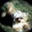

In [5]:
from IPython.display import Image
Image(filename='./data/train/dog/3133.png') 

In [14]:
config.checkpoint

'cross_entropy'

In [ ]:
net.get_model()

In [17]:
import torch.nn as nn

# outputs.shape
from collections import OrderedDict

inputs = torch.randn((1,3,32,32))

inputs = inputs.cuda()
targets_fast = torch.tensor([1])
# net = get_model()

outputs = net.forward(inputs)
#net.eval()
criterion = nn.CrossEntropyLoss()

fast_loss = criterion(outputs,targets_fast.cuda())

grads = torch.autograd.grad(fast_loss, net.parameters(), create_graph=True, retain_graph=True, only_inputs=True)
with torch.no_grad():
    fast_weights = OrderedDict((name, param - 0.2*grad) for ((name, param), grad) in zip(net.named_parameters(), grads))
# for grad in grads:
#     grad.requires_grad = False  
fast_out = net.forward(inputs,fast_weights)  

In [18]:
config.model

'resnet34'

In [19]:
net.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=Fals